Questions:
1. Is the model correctly specified?
2. Do I need to test a distribution for multimodality or do the graph's make it apparent enough?

to do:
1. grid of graphs
2. scatter plot of popularity
3. 

Implement 3 descriptive techniques:

1. popularity. Show the degree distribution, test if it follows a scale free degree distribution
    1. fit the scale-free pdf to the degree distribution
    2. test the hypothesis that the degrees were generated from the fitted distribution
    3. plot the log scale degree distribution. If it is linear with a negative slope that indicates a scale-free distribution
        

2. centrality
    1. measure centrality of political elites
    2. size nodes according to their centrality
    3. probably apply a measure of betweenness centrality
    

3. assortative mixing. homophily. Do this with the retweet network rather than the follower network.
    1. calculate assortivity coefficients
    

In [3]:
library(igraph)
library(dplyr)
library(Matrix)
library(ggplot2)
library(gridExtra)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Data prep

In [2]:
# load follower adjacency matrix. matrix named 'y'
load('Barbera/adj-matrix-US.rdata')

# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')

# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

# load elites data. df named 'results'
load('Barbera/results-elites-US.rdata')

In [3]:
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')

followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')

nodes <- rbind(followers, elites)

In [4]:
# subset into left and right based on theta
# calculate degree for each uid
# fit power law
# subset to candidate specific tweets
obama <- retweets[retweets$candidate == 'Obama',c(2,3)]
romney <- retweets[retweets$candidate == 'Romney',c(2,3)]

## Popularity followers

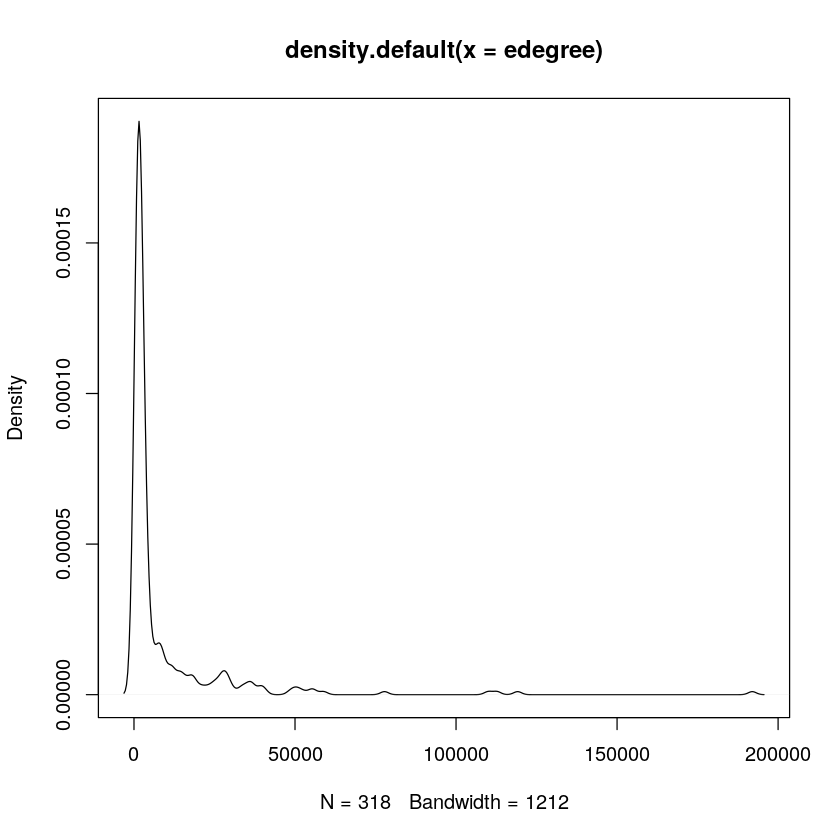

In [8]:
# plot the degree distribution for elites

# sum the columns for elites
edegree <- as.matrix(colSums(y))
# plot the distribution
plot(density(edegree))

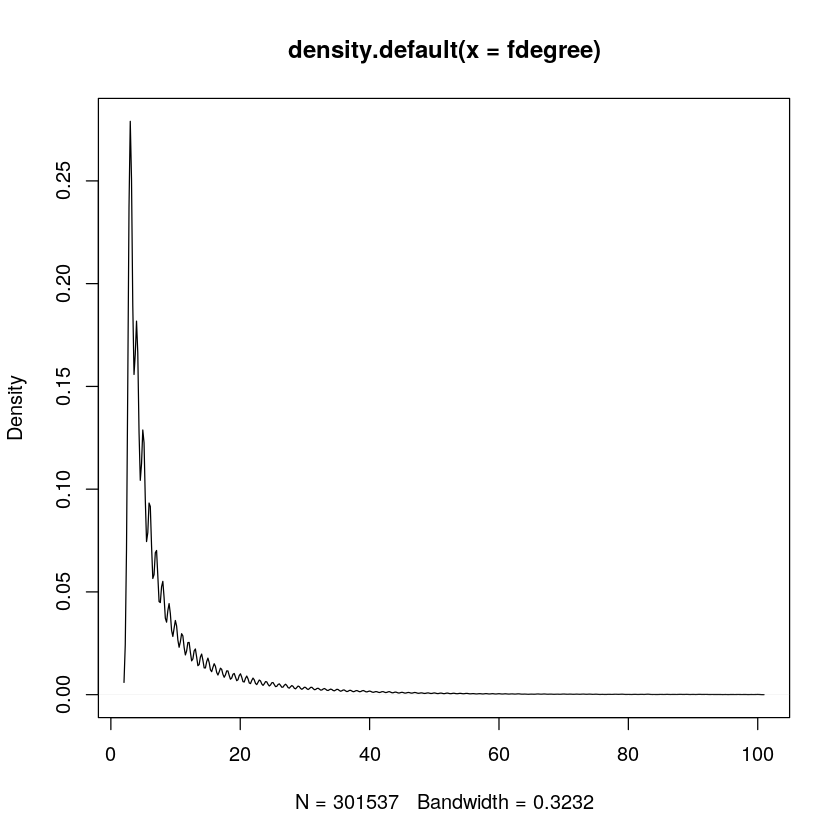

In [7]:
# sum the columns for followers
fdegree <- as.matrix(rowSums(y))
# plot the distribution
plot(density(fdegree))

In [67]:
fit_power_law(edegree)

$continuous
[1] FALSE

$alpha
[1] 1.701113

$xmin
[1] 846

$logLik
[1] -2789.346

$KS.stat
[1] 0.05297508

$KS.p
[1] 0.3834277

## Popularity retweet

In [6]:
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))
# get the degree of nodes in the retweet network
d_retweet <- degree(g_retweet)

# Identify outliers
outliers <- boxplot(d_retweet, plot=FALSE)$out

# drop from the list
d_noout<- d_retweet[-which(d_retweet %in% outliers)]

# histogram without outliers
d_hist <- ggplot(as.data.frame(d_noout), aes(x=d_noout)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme_bw()

# histogram with outliers
d_histout <- ggplot(as.data.frame(d_retweet), aes(x=d_retweet)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme_bw()

# plot side by side
degree_grid <- grid.arrange(d_histout, 
                           d_hist, 
                           ncol = 2)

# save
ggsave('plots/degree.png', plot = degree_grid, width = 10, height = 5)

# Attachment

In [15]:
# histogram of degree
d_hist <- hist(d_retweet)

# Plot attachment
png('plots/attachment.png', width = 500, height = 500)
plot(1:length(d_hist$counts), d_hist$counts+1, xlab = "Degree", ylab = "Frequency", cex.lab = 1.5, main = "Scale-Free (log-log scale)", log = "xy", type = "b")
dev.off()

png 
  2

In [16]:
# power law fit
fit_power_law(d_retweet)

$continuous
[1] FALSE

$alpha
[1] 2.487881

$xmin
[1] 1434

$logLik
[1] -11446.73

$KS.stat
[1] 0.01664783

$KS.p
[1] 0.8515818

## Assortativity

In [4]:
# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')
# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

# create the initial graph
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

# get a list of all nodes in the data set
edgeids <- V(g_retweet)$name

users <- users[,c(9, 1, 8)]
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% users$uid)]
# remove nodes with no point estimate
g <- delete_vertices(g_retweet, missing)
# create a new edge list
retweets_clean <- igraph::as_data_frame(g, what = 'edges')
# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = users)


# repeat this for all ideological groups

# subset to cons, lib, and mod data frames
c_users <- users[users$type == 'Conservatives', c('uid', 'theta', 'type')]
# get a list of nodes not in the list of cons users
c_missing <- edgeids[-which(edgeids %in% c_users$uid)]
# delete those users from the graph
c_retweet <- delete_vertices(g_retweet, c_missing)
# get a clean edge list
c_clean <- igraph::as_data_frame(c_retweet, what = 'edges')
# create a new graph object
cg <- graph_from_data_frame(c_clean, directed = TRUE, vertices = c_users)


l_users <- users[users$type == 'Liberals', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
l_missing <- edgeids[-which(edgeids %in% l_users$uid)]
# delete those users from the graph
l_retweet <- delete_vertices(g_retweet, l_missing)
# get a clean edge list
l_clean <- igraph::as_data_frame(l_retweet, what = 'edges')
# create a new graph object
lg <- graph_from_data_frame(l_clean, directed = TRUE, vertices = l_users)

m_users <- users[users$type == 'Moderates', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
m_missing <- edgeids[-which(edgeids %in% m_users$uid)]
# delete those users from the graph
m_retweet <- delete_vertices(g_retweet, m_missing)
# get a clean edge list
m_clean <- igraph::as_data_frame(m_retweet, what = 'edges')
# create a new graph object
mg <- graph_from_data_frame(m_clean, directed = TRUE, vertices = m_users)

In [141]:
# lower assortativity in partisan networks indicates
# propensity to retweet disagreements
assortativity(g, types1 = V(g)$theta)
assortativity(cg, types1 = V(cg)$theta)
assortativity(lg, types1 = V(lg)$theta)
assortativity(mg, types1 = V(mg)$theta)

[1] 0.7462079

[1] 0.1278305

[1] 0.2700945

[1] 0.7551174

## Transitivity

In [76]:
# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')

# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')
# subset user data to uid and theta columns
users <- users[,c(9, 1, 8)]

# create the initial graph
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

# get a list of all vertex names in the original edge list
edgeids <- V(g_retweet)$name
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% users$uid)]
# remove nodes with no point estimate
g_retweet <- delete_vertices(g_retweet, missing)
# create a new edge list
retweets_clean <- igraph::as_data_frame(g_retweet, what = 'edges')

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = users)

# assign transitivity
V(g)$trans <- transitivity(g, 'local')

# transitivity of conservatives
mean(V(g)[V(g)$type == 'Conservatives']$trans, na.rm = TRUE)

mean(V(g)[V(g)$type == 'Liberals']$trans, na.rm = TRUE)

mean(V(g)[V(g)$type == 'Moderates']$trans, na.rm = TRUE)

mean(V(g)$trans, na.rm = TRUE)
transitivity(g)

[1] 0.1529686

[1] 0.1462013

[1] 0.1170393

[1] 0.1278535

In [78]:
median(V(g)[V(g)$type == 'Conservatives']$trans, na.rm = TRUE)

median(V(g)[V(g)$type == 'Liberals']$trans, na.rm = TRUE)

median(V(g)[V(g)$type == 'Moderates']$trans, na.rm = TRUE)

[1] 0.1215846

[1] 0.1071429

[1] 0.06666667

In [127]:
# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')
# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

users <- users[,c(9, 1, 8)]
# create the initial graph
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

# get a list of all nodes in the data set
edgeids <- V(g_retweet)$name

# subset to cons, lib, and mod data frames
c_users <- users[users$type == 'Conservatives', c('uid', 'theta', 'type')]
# get a list of nodes not in the list of cons users
c_missing <- edgeids[-which(edgeids %in% c_users$uid)]
# delete those users from the graph
c_retweet <- delete_vertices(g_retweet, c_missing)
# get a clean edge list
c_clean <- igraph::as_data_frame(c_retweet, what = 'edges')
# create a new graph object
cg <- graph_from_data_frame(c_clean, directed = TRUE, vertices = c_users)


l_users <- users[users$type == 'Liberals', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
l_missing <- edgeids[-which(edgeids %in% l_users$uid)]
# delete those users from the graph
l_retweet <- delete_vertices(g_retweet, l_missing)
# get a clean edge list
l_clean <- igraph::as_data_frame(l_retweet, what = 'edges')
# create a new graph object
lg <- graph_from_data_frame(l_clean, directed = TRUE, vertices = l_users)

m_users <- users[users$type == 'Moderates', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
m_missing <- edgeids[-which(edgeids %in% m_users$uid)]
# delete those users from the graph
m_retweet <- delete_vertices(g_retweet, m_missing)
# get a clean edge list
m_clean <- igraph::as_data_frame(m_retweet, what = 'edges')
# create a new graph object
mg <- graph_from_data_frame(m_clean, directed = TRUE, vertices = m_users)


In [78]:
# global transitivity for when network is subsetset by ideological group
transitivity(cg, 'global')
transitivity(lg, 'global')
transitivity(mg, 'global')

[1] 0.08086102

[1] 0.1478553

[1] 0.08806405

# Centrality

In [89]:
# calculate degree centrality with cutoff of 3
cent <- estimate_betweenness(g, directed = TRUE, cutoff = 3)
# assign as attribute
V(g)$cent <- cent

In [147]:
save(cent, file = 'centrality.rdata')

In [67]:
load('centrality.rdata')
V(g)$cent <- cent

In [71]:
# outliers dominate to the point that mean and median are useless
# accordingly take the log and then the mean

mean(log(V(g)[V(g)$type == 'Conservatives']$cent + 1))
mean(log(V(g)[V(g)$type == 'Liberals']$cent + 1))
mean(log(V(g)[V(g)$type == 'Moderates']$cent + 1))
mean(log((V(g)$cent + 1)))

[1] 3.479205

[1] 3.113419

[1] 1.795151

[1] 1.221542

# Recpiprocity

In [174]:
# create a graph from the edge list
g <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))
# get a list of all vertex names in the original edge list
edgeids <- V(g)$name

# get a list of all vertex names in the elites and followers data
# elites data
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')
# followers data
followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')
# combine elites and followers data
nodes <- rbind(followers, elites)

# remove vertices with no point estimates from the data
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% nodes$uid)]
# remove nodes from the network with no point estimate
g <- delete_vertices(g, missing)
# create a new edge list after dropping vertices
retweets_clean <- igraph::as_data_frame(g, what = 'edges')

# add meta data to the node list
# count number of times a node retweeted someone else
retweet_count <- count(retweets_clean, from)
colnames(retweet_count) <- c('uid', 'retweets')
# count the number of times a node was retweeted
retweeted_count <- count(retweets_clean, to)
colnames(retweeted_count) <- c('uid', 'retweeted')
# left join retweets with node list
nodes <- left_join(nodes, retweet_count, by = 'uid')
# left join retweeted with node list
nodes <- left_join(nodes, retweeted_count, by = 'uid')
# fill NA with zero 
nodes$retweets[is.na(nodes$retweets)] <- 0
nodes$retweeted[is.na(nodes$retweeted)] <- 0

# add reciprocity
# create retweet adjacency matrix
retweet_adj <- as_adj(g, edges=TRUE, sparse = TRUE)
# convert from numeric to binary sparse matrix
retweet_adj <- as(retweet_adj, "ngCMatrix")
# multiply the matrix aby its inverse and sum the rows to get the number of reciprocated ties
recip <- as.matrix(rowSums(retweet_adj*t(retweet_adj)))
# convert to df for joining
recip <- as.data.frame(recip)
recip$uid <- rownames(recip)
colnames(recip) <- c('reciprocity', 'uid')
# join to node list
nodes <- left_join(nodes, recip, by = 'uid')
# replace NA with 0
nodes$reciprocity[is.na(nodes$reciprocity)] <- 0

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = nodes)

In [189]:
reciprocity(mg)

[1] 0.053076

In [176]:
recip_scatter <- ggplot(nodes, aes(x=ideal_point, y=reciprocity)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Reciprocity') +
    theme_bw()

In [198]:
# avg number of mutual ties for conservatives
mean(nodes[nodes$ideal_point >= 0.5, 'reciprocity'])

# avg number of mutual ties for Liberals
mean(nodes[nodes$ideal_point <= -0.5, 'reciprocity'])

# average number for moderates
mean(nodes[nodes$ideal_point >= -0.5 & nodes$ideal_point <= 0.5, 'reciprocity'])

[1] 0.9576613

[1] 0.587626

[1] 0.1694838

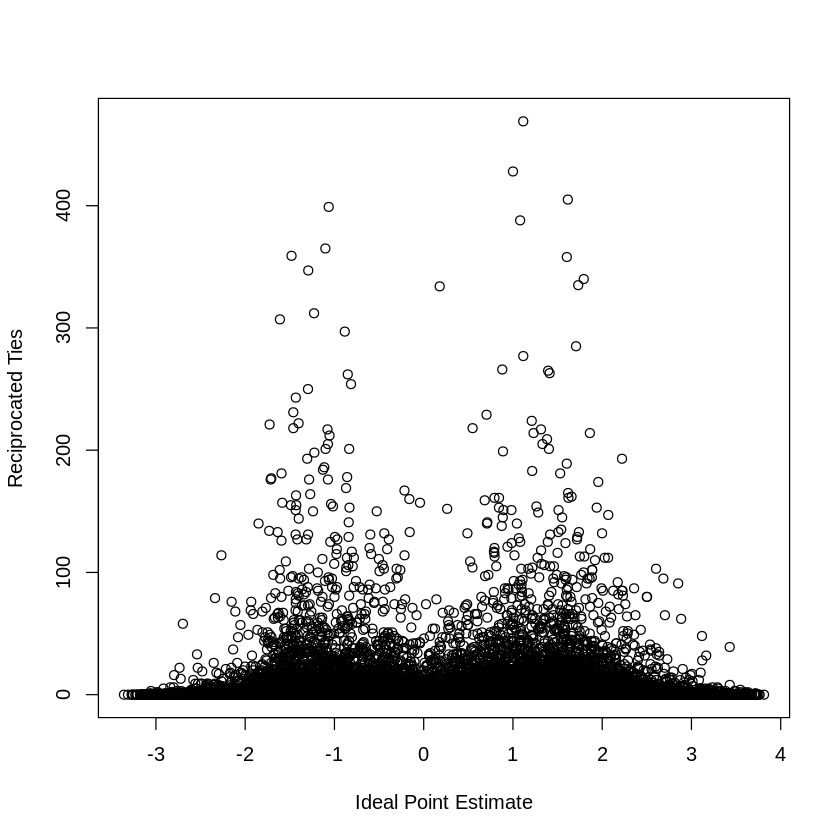

In [177]:
# reciprocity distribution by ideal point
recip_scatter <- plot(nodes$ideal_point, nodes$reciprocity, 
                      xlab = 'Ideal Point Estimate', 
                      ylab = 'Reciprocated Ties')

In [14]:
retweet_scatter <- ggplot(nodes, aes(x=ideal_point, y=retweets)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Retweets') +
    theme_bw()

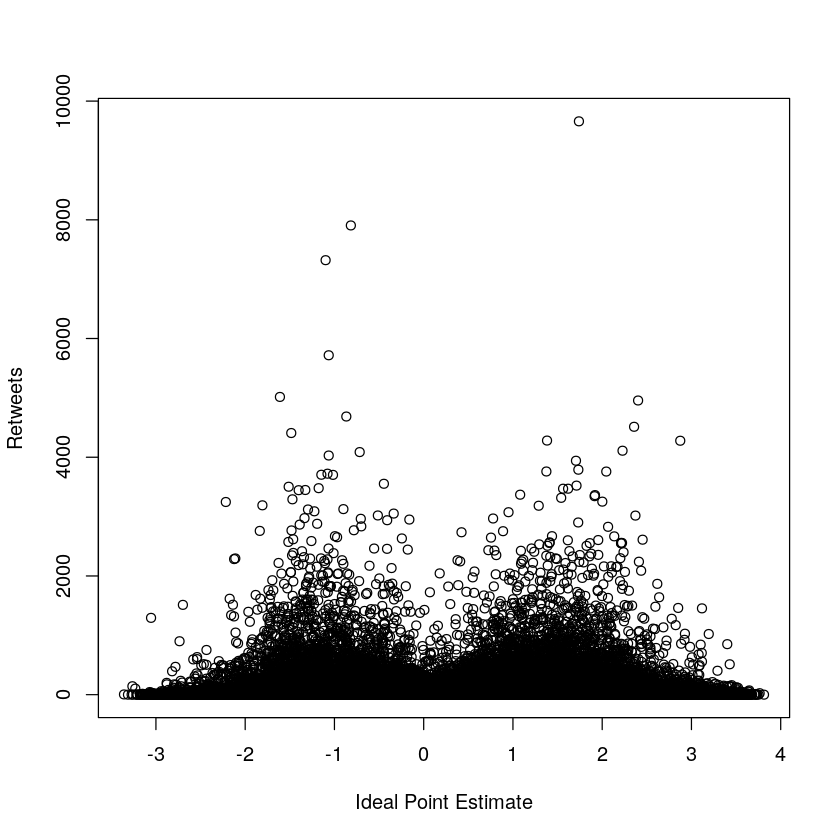

In [28]:
retweet_scatter <- plot(nodes$ideal_point, nodes$retweets,
                       xlab = 'Ideal Point Estimate',
                       ylab = 'Retweets')

In [15]:
retweeted_scatter <- ggplot(nodes, aes(x=ideal_point, y=retweeted)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Retweeted') +
    theme_bw()

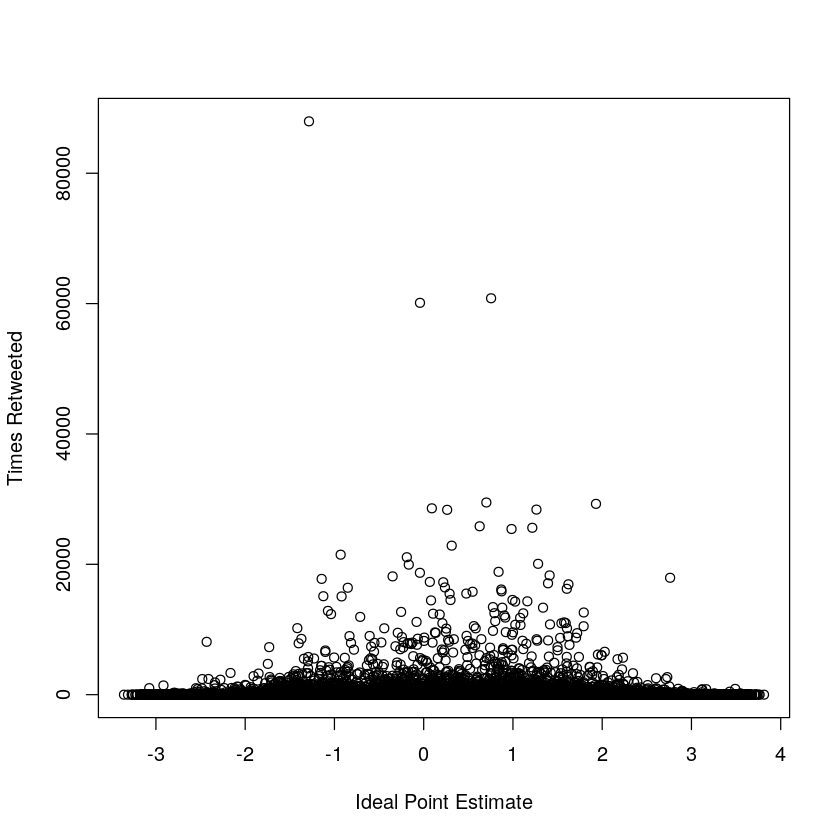

In [29]:
retweeted_scatter <- plot(nodes$ideal_point, nodes$retweeted,
                         xlab = 'Ideal Point Estimate',
                         ylab = 'Times Retweeted')

In [8]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




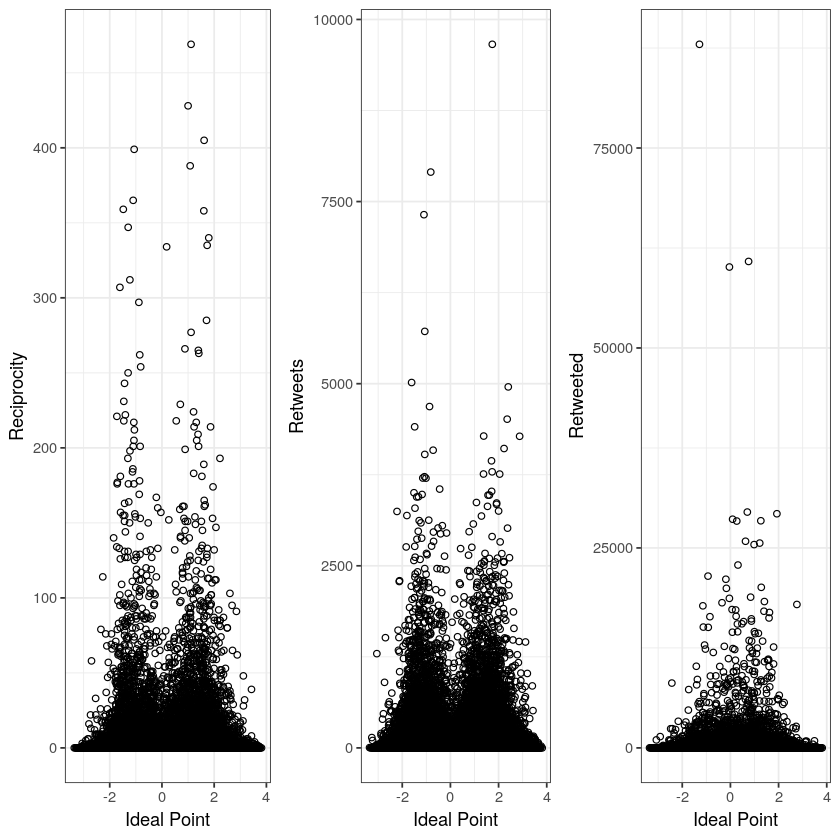

In [17]:
recip_grid <- grid.arrange(recip_scatter, 
                           retweet_scatter, 
                           retweeted_scatter, 
                           ncol = 3)

ggsave('reciprocity.png', plot = recip_grid, width = 15, height = 5)

In [ ]:
# add elite/follower tag
# add ideological group tag
# tag based on candidate mentioned in the tweet

# Show reciprocity by elite/user

# Retweet network plot

In [14]:
retweetfr <- layout_with_fr(g_retweet, grid = 'nogrid')
save(retweetfr, file = "retweet_fr_layout.RData")

In [6]:
load('retweet_fr_layout.RData')

In [ ]:
plot.igraph(g_retweet, 
     layout = retweetfr,
     vertex.label = NA,
     vertex.size = 1.5,
     vertex.frame.color = NA,
     edge.color ='gray',
     edge.width = .25
    )

In [22]:
library(igraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [33]:
load('Barbera/users-data-US.rdata')
load('Barbera/retweets-data.rdata')


users <- users[,c(9, 1)]
rtdf <- retweets[retweets$retweeter_uid %in% users$uid, ]
rtdf <- rtdf[(rtdf$retweeted_uid %in% users$uid), ]

grt <- graph_from_data_frame(rtdf[,c(2,3)], vertices = users, directed = FALSE)

#grt <- simplify(grt)

V(grt)$ degree <- degree(grt)

df <- as_data_frame(grt, what = 'vertices')
head(df)

In [57]:
sing <- which(degree(grt)<=100)
grt2 = delete.vertices(grt, sing)

In [ ]:
retweetfr <- layout_with_fr(g_retweet, grid = 'nogrid')
save(retweetfr, file = "retweet_fr_layout2.RData")

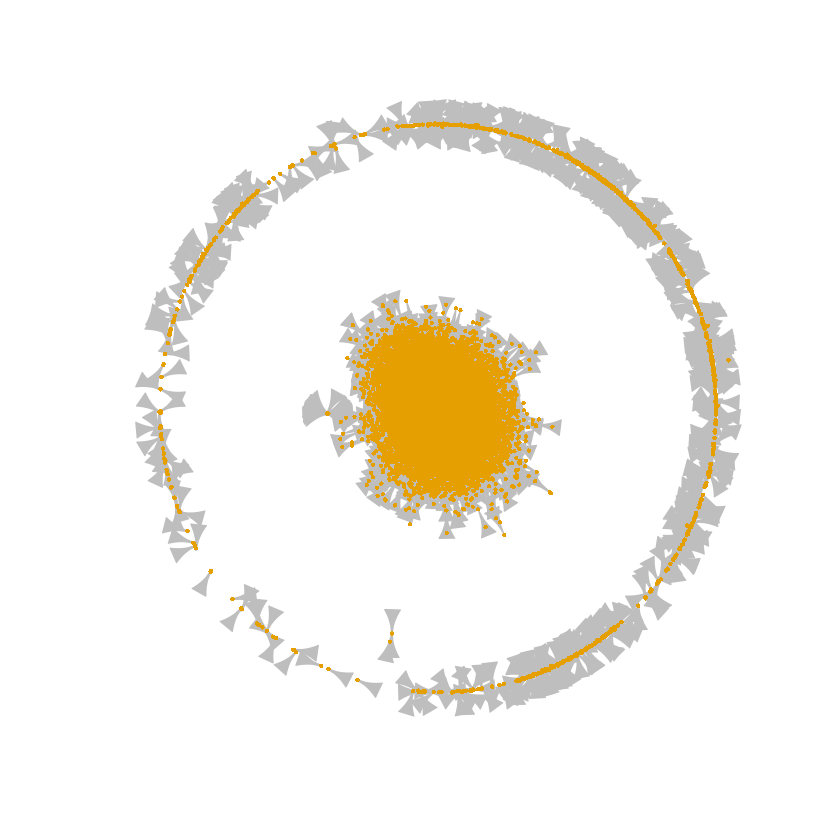

In [4]:
load('Barbera/retweets-data.rdata')
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]), directed = FALSE)
g_retweet <- simplify(g_retweet)

load('retweet_fr_layout.RData')

plot.igraph(g_retweet, 
     layout = retweetfr,
     vertex.label = NA,
     vertex.size = 1.5,
     vertex.frame.color = NA,
     edge.color ='gray',
     edge.width = .25
    )

## Heatmap

In [4]:
library(ggplot2)

In [38]:
load('Barbera/users-data-US.rdata')
head(users)

,theta,alpha,state,country,uzip,lat,lon,type,uid
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
213795,-1.4800342,-1.475352,Georgia,United States,30303,33.74831,-84.39111,NA,us1
300363,-0.3878467,-1.853607,Maryland,United States,21154,39.66798,-76.37919,NA,us10
245845,0.1688528,-1.684275,Alaska,United States,NA,NA,NA,NA,us100
139520,0.8711387,-2.063020,Texas,United States,75254,32.95398,-96.81689,NA,us1000
184679,0.6074411,-1.337793,Pennsylvania,United States,17033,40.28532,-76.65105,NA,us10000
242790,-1.0361716,-1.485082,North Carolina,United States,28801,35.59846,-82.55314,NA,us100000


In [45]:
load('Barbera/users-data-US.rdata')
load('Barbera/retweets-data.rdata')


users <- users[,c(9, 1)]
rtdf <- retweets[retweets$retweeter_uid %in% users$uid, ]
rtdf <- rtdf[(rtdf$retweeted_uid %in% users$uid), ]

grt <- graph_from_data_frame(rtdf[,c(2,3)], vertices = users, directed = FALSE)

V(grt)$ degree <- degree(grt)

df <- as_data_frame(grt, what = 'vertices')

Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


ERROR: Error in as.data.frame.default(value, stringsAsFactors = FALSE): cannot coerce class ‘"igraph"’ to a data.frame


In [61]:
rtvis <- ggplot(users, aes(x=theta, y=alpha) ) +
  geom_bin2d(bins = 300) +
  ylab(expression('Popularity'[i])) + # put a line through the graph when I label this alpha for some reason...
  xlab(expression(theta[i])) +
  scale_fill_continuous(type = "viridis", name = 'Count') +
  theme(panel.border=element_rect(fill=NA), panel.background = element_blank())

ggsave(filename="plots/retweet_net.png", plot=rtvis, 
        height=5, width=5)

In [60]:
V(g)$degree <- degree(g)
users <- igraph::as_data_frame(g, what = 'vertices')

cor(abs(users[users$theta >= 0.5, 'theta']), users[users$theta >= 0.5, 'degree'])

cor(abs(users[users$theta <= -0.5, 'theta']), users[users$theta <= -0.5, 'degree'])

cor(abs(users[users$theta >= -0.5 & users$theta <= 0.5, 'theta']), users[users$theta >= -0.5 & users$theta <= 0.5, 'degree'])

[1] 0.017164

[1] 0.02037282

[1] 0.0007133533

In [62]:
load('Barbera/users-data-US.rdata')
cor(abs(users[users$theta >= 0.5, 'theta']), users[users$theta >= 0.5, 'alpha'])

cor(abs(users[users$theta <= -0.5, 'theta']), users[users$theta <= -0.5, 'alpha'])

cor(abs(users[users$theta >= -0.5 & users$theta <= 0.5, 'theta']), users[users$theta >= -0.5 & users$theta <= 0.5, 'alpha'])

[1] 0.1074937

[1] 0.2121824

[1] -0.08575468

In [54]:
cor(abs(users$theta), users$alpha)

[1] 0.1792304

### Centrality

In [151]:
df <- igraph::as_data_frame(g, what = 'vertices')

In [148]:
V(g)$cent <- cent

In [ ]:
print(test)

Warning message:
“Removed 238780 rows containing non-finite values (stat_bin2d).”


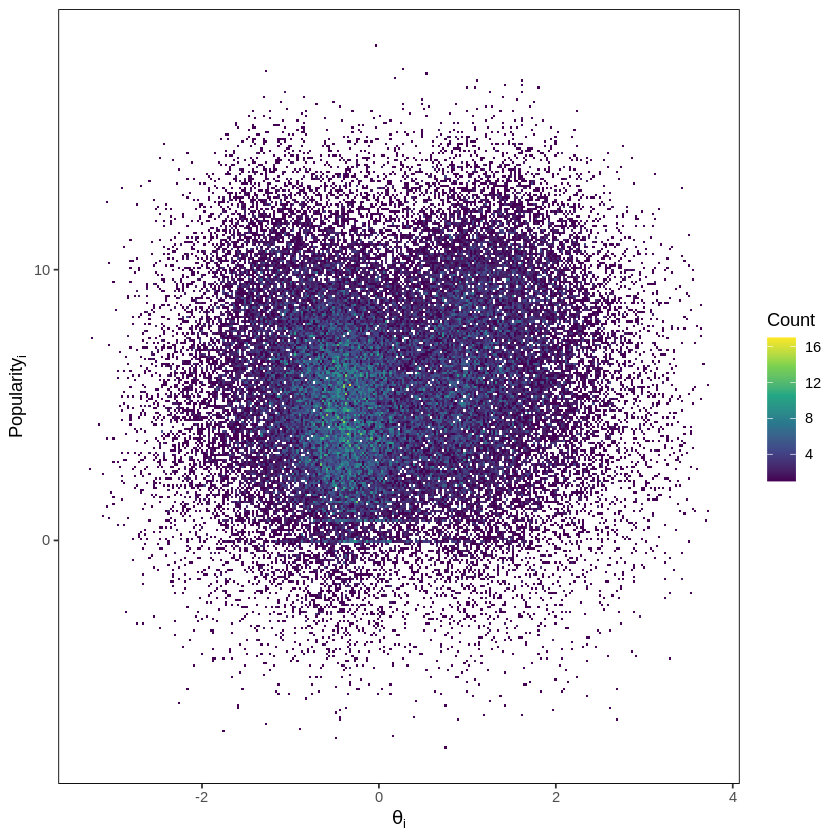

In [164]:
ggplot(df, aes(x=theta, y = log(cent) )) +
  geom_bin2d(bins = 300) +
  ylab(expression('Popularity'[i])) + # put a line through the graph when I label this alpha for some reason...
  xlab(expression(theta[i])) +
  scale_fill_continuous(type = "viridis", name = 'Count') +
  theme(panel.border=element_rect(fill=NA), panel.background = element_blank())
